# 2.2 ETL Feature Engineering Notebook

Load essential packages for data access, manipulation, and file handling.

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Contents

1. Load Datasets: Raw vs. Imputed  
1.1 Drop Redundant or Constant Features  
1.2 Check Feature Distributions  

2. Feature Engineering  
2.1 Interaction Terms (e.g., cdi × nst)  
2.2 Binning and Scaling  
2.3 Correlation and VIF Analysis  

3. Export Transformed Dataset

## 1. Load Datasets: Raw vs. Imputed

We import two versions of the earthquake dataset to support dual-path benchmarking:

- **Raw Dataset** (`earthquake_data_tsunami.csv`):  
  Contains original features with missing values. Used for missingness analysis, imputation strategy comparison, and robustness testing.

- **Imputed Dataset** (`earthquake_imputed.csv`):  
  Contains preprocessed features with missing values filled. Used for feature engineering, model training, and performance benchmarking.

This dual import allows us to:
- Compare model performance with vs. without imputation
- Audit the impact of preprocessing on feature distributions and interactions
- Apply validator-grade logic to assess parsimony, drift, and attribution stability

In [2]:
# Load imputed dataset (used for feature engineering and ML benchmarking)
imputed_df = pd.read_csv("../data/processed/earthquake_imputed.csv")

# Load raw dataset (used for missingness analysis, imputation benchmarking, and model robustness testing)
raw_df = pd.read_csv("../data/raw/earthquake_data_tsunami.csv")

## 1.1 Drop Redundant or Constant Features

We perform a diagnostic audit to identify features that may be redundant, constant, or quasi-constant. This step supports the principle of parsimony and prepares for downstream correlation and VIF analysis.

No features are dropped at this stage — we log candidates for potential removal based on:

- **Zero variance**: Features with identical values across all rows
- **Quasi-constant**: Features dominated by a single value (e.g., >99% frequency)
- **Duplicate columns**: Identical feature vectors
- **Manual flags**: ID-like or metadata columns with no predictive value

This audit is applied to both the raw and imputed datasets to support dual-path benchmarking.

In [3]:
# Define audit function for constant, quasi-constant, and duplicate features
def audit_redundant_features(df, name="dataset", quasi_thresh=0.99):
    print(f"\n🔍 Auditing {name} for redundant features...")

    # Constant features (zero variance)
    constant_cols = [col for col in df.columns if df[col].nunique() == 1]
    print(f"🧱 Constant features: {constant_cols}")

    # Quasi-constant features
    quasi_cols = []
    for col in df.columns:
        top_freq = df[col].value_counts(normalize=True, dropna=False).max()
        if top_freq > quasi_thresh and col not in constant_cols:
            quasi_cols.append(col)
    print(f"🧊 Quasi-constant features (>{quasi_thresh*100:.0f}% dominance): {quasi_cols}")

    # Duplicate columns
    dup_cols = df.T[df.T.duplicated()].index.tolist()
    print(f"📎 Duplicate columns: {dup_cols}")

    # Summary
    flagged = set(constant_cols + quasi_cols + dup_cols)
    print(f"⚠️ Total flagged features in {name}: {len(flagged)}")
    return flagged

# Run audits on both datasets
flagged_raw = audit_redundant_features(raw_df, name="Raw Dataset")
flagged_imputed = audit_redundant_features(imputed_df, name="Imputed Dataset")


🔍 Auditing Raw Dataset for redundant features...
🧱 Constant features: []
🧊 Quasi-constant features (>99% dominance): []
📎 Duplicate columns: []
⚠️ Total flagged features in Raw Dataset: 0

🔍 Auditing Imputed Dataset for redundant features...
🧱 Constant features: []
🧊 Quasi-constant features (>99% dominance): []
📎 Duplicate columns: []
⚠️ Total flagged features in Imputed Dataset: 0


### Audit Summary: No Redundant Features Found

The audit identified **no constant, quasi-constant, or duplicate features** in either the raw or imputed dataset.

This confirms:
- All features exhibit sufficient variance and uniqueness
- No immediate candidates for removal based on parsimony or redundancy
- Feature pruning will be deferred to downstream correlation and VIF analysis (Section 2.3)

This outcome supports the integrity of the current feature set and validates the preprocessing pipeline up to this stage.

## 1.2 Check Feature Distributions

We visualize and summarize feature distributions to support scaling, binning, and interaction logic in downstream engineering steps.

This diagnostic is applied to both raw and imputed datasets to:
- Confirm data integrity and detect anomalies
- Benchmark imputation impact on distribution shape
- Support decisions around log transforms, normalization, and binning
- Prepare for interaction term modeling and VIF analysis

Sentinel values (`-999`) are excluded **only for the feature being plotted** to avoid artificial bimodality and preserve valid data in other columns.

No transformations are applied at this stage — this is a feature-level audit checkpoint.


📊 Plotting distributions for Raw Dataset (13 numeric features)...


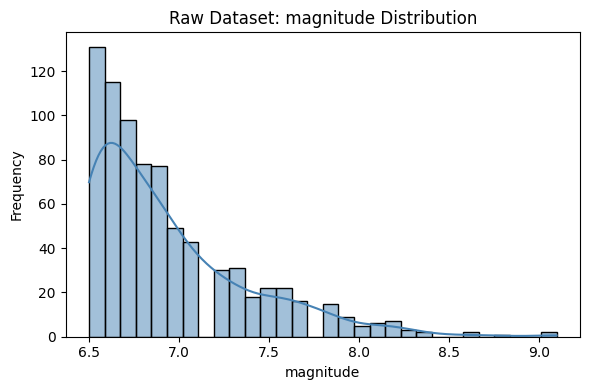

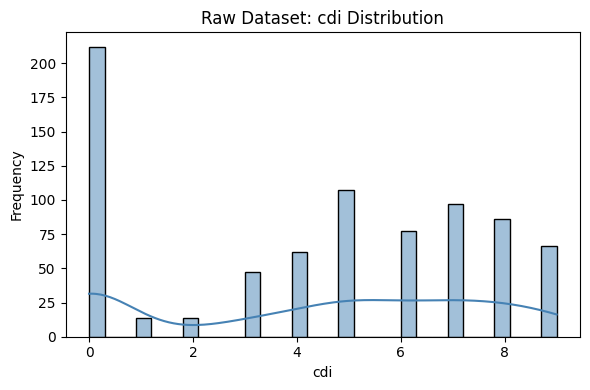

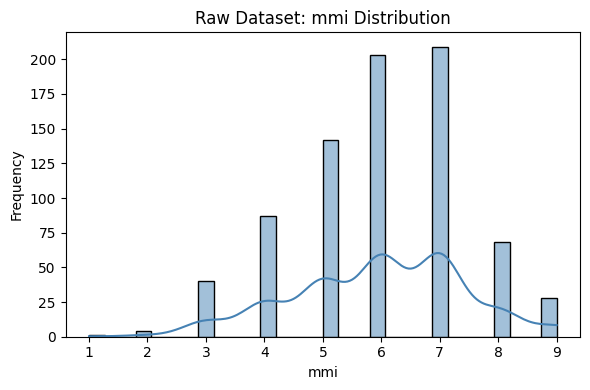

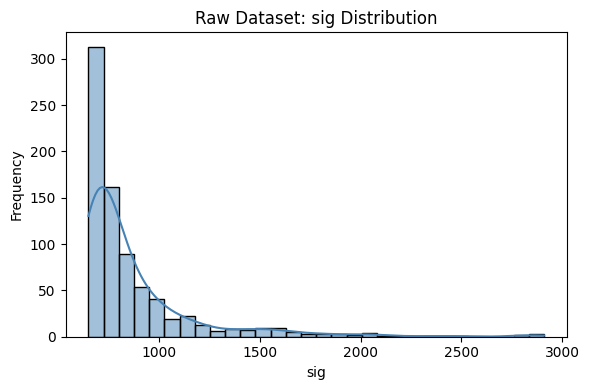

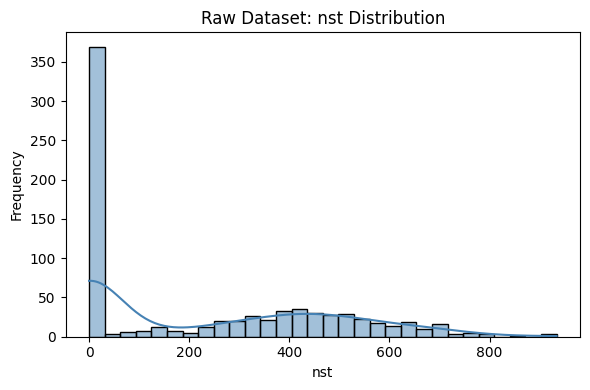

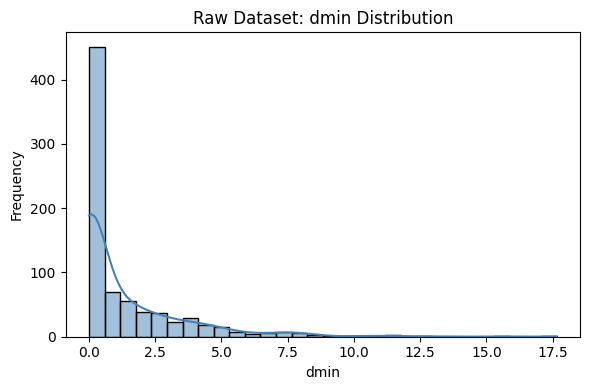

🛑 Display limit reached (6 plots).

📊 Plotting distributions for Imputed Dataset (13 numeric features)...


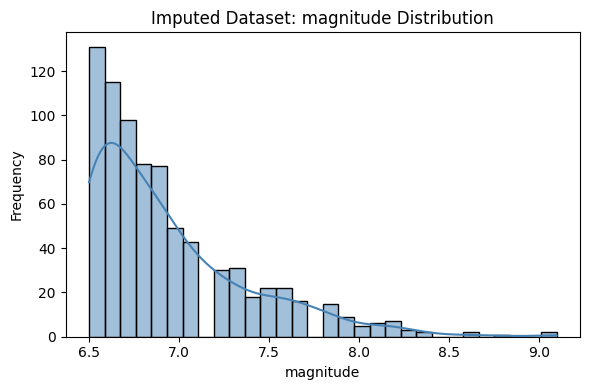

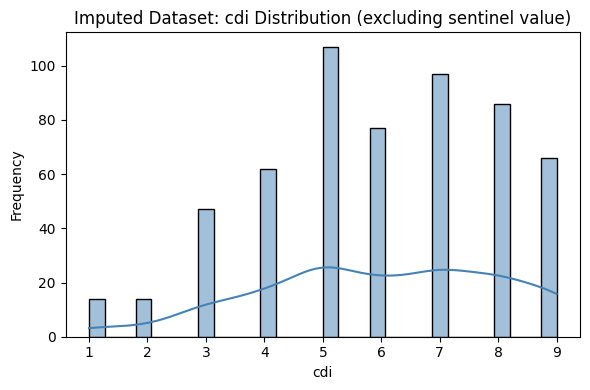

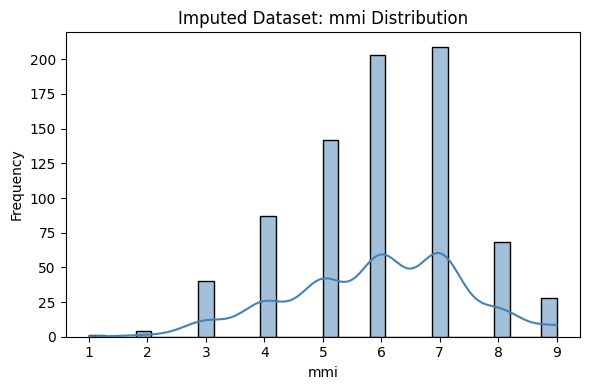

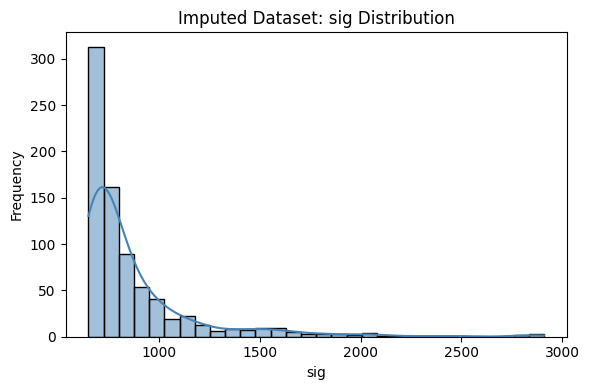

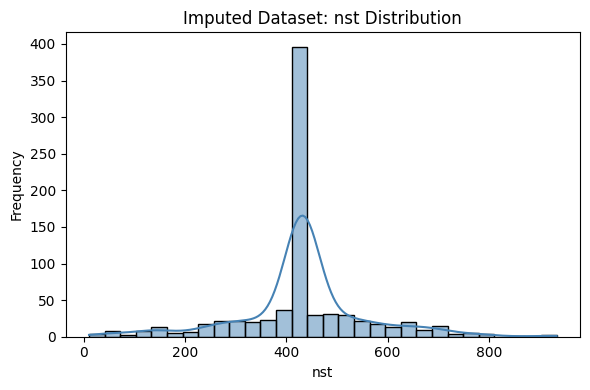

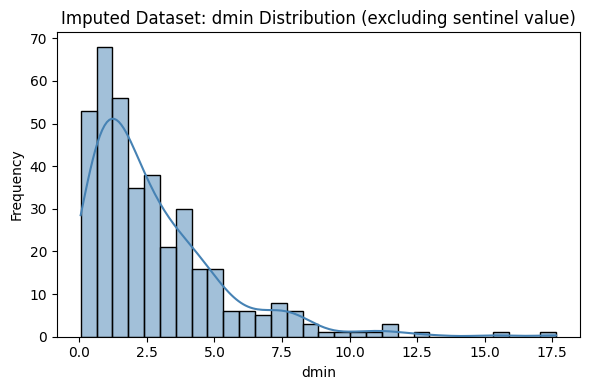

🛑 Display limit reached (6 plots).


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distributions(df, name="dataset", sentinel=-999, max_cols=6):
    numeric_cols = df.select_dtypes(include="number").columns.tolist()
    print(f"\n📊 Plotting distributions for {name} ({len(numeric_cols)} numeric features)...")

    for i, col in enumerate(numeric_cols):
        col_data = df[col]
        filtered_data = col_data[col_data != sentinel]
        dropped_count = len(col_data) - len(filtered_data)

        # Dynamic title logic
        title_suffix = f" (excluding sentinel value)" if dropped_count > 0 else ""
        plt.figure(figsize=(6, 4))
        sns.histplot(filtered_data, kde=True, bins=30, color="steelblue")
        plt.title(f"{name}: {col} Distribution{title_suffix}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

        if i >= max_cols - 1:
            print(f"🛑 Display limit reached ({max_cols} plots).")
            break

# Plot distributions for both datasets
plot_feature_distributions(raw_df, name="Raw Dataset")
plot_feature_distributions(imputed_df, name="Imputed Dataset")